VIDEO TESTING IN TENSORFLOW

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Access Google Drive Folder
import os
COLAB_PATH = "gdrive/MyDrive"
os.chdir(COLAB_PATH)

In [ ]:
# Enter to yolov7 folder
%cd yolov7
!ls

/content/gdrive/MyDrive/yolov7
 best.onnx		    LICENSE.md		   yolov7_model.tflite
 best.pt		    models		   yolov7.pt
 best.torchscript.pt	    paper		   yolov7_training.pt
 best.torchscript.ptl	    __pycache__		   yolov7_training.pt.1
 cfg			    README.md		   yolov7_training.pt.10
'Copy of last.pt'	    requirements_gpu.txt   yolov7_training.pt.11
 data			    requirements.txt	   yolov7_training.pt.12
 deep_sort_pytorch	    runs		   yolov7_training.pt.13
 deep_sort_pytorch.zip	    scripts		   yolov7_training.pt.14
 deep_sort_tracking_id.py   shih-tzu.mp4	   yolov7_training.pt.15
 deploy			    tensorflow		   yolov7_training.pt.2
 detect_mask.py		    test.py		   yolov7_training.pt.3
 detect_pose.py		    tf_lite		   yolov7_training.pt.4
 detect.py		    TF_LITE_MODEL	   yolov7_training.pt.5
 export.py		    tools		   yolov7_training.pt.6
 figure			    traced_model.pt	   yolov7_training.pt.7
 hubconf.py		    train_aux.py	   yolov7_training.pt.8
 inference		    train.py		   yolov7_training.pt.9


In [ ]:
import cv2
import time
import requests
import random
import numpy as np
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="yolov7_model.tflite")

In [ ]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

#Name of the classes according to class indices.
names = ['Sitting','Layingdown','Standing','Jumping','Running']

#Creating random colors for bounding box visualization.
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

#Load and preprocess the image.
img = cv2.imread('kk.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255


#Allocate tensors.
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], im)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

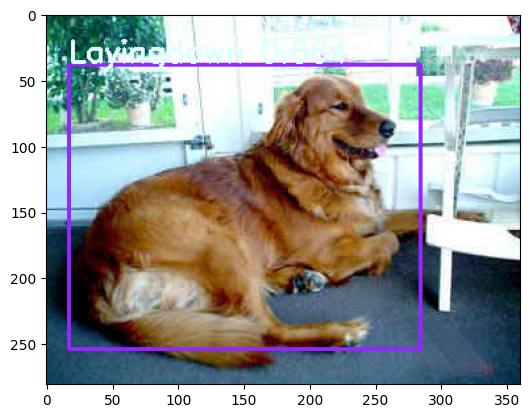

In [ ]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(output_data):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)
plt.imshow(ori_images[0])

In [ ]:
import cv2
import numpy as np
import random
import tensorflow as tf
from google.colab.patches import cv2_imshow

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="yolov7_model.tflite")

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

# Name of the classes according to class indices.
names = ['Sitting', 'Standing', 'Layingdown', 'Running']

# Creating random colors for bounding box visualization.
colors = {name: [random.randint(0, 255) for _ in range(3)] for i, name in enumerate(names)}

# Load the video
video_path = 'shih-tzu.mp4'
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create a VideoWriter object
output_path = '/runs/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="yolov7_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    im /= 255

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], im)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    output_data = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

    # Process the output
    ori_images = [img.copy()]
    for i, (batch_id, x0, y0, x1, y1, cls_id, score) in enumerate(output_data[0]):
        image = ori_images[int(batch_id)]
        box = np.array([x0, y0, x1, y1])
        box -= np.array(dwdh * 2)
        box /= ratio
        box = box.round().astype(np.int32).tolist()
        cls_id = int(cls_id)
        score = round(float(score), 3)
        name = names[cls_id]
        color = colors[name]
        name += ' ' + str(score)
        cv2.rectangle(image, box[:2], box[2:], color, 2)
        cv2.putText(image, name, (box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)

    # Convert the image back to BGR for writing to the output video
    frame_with_boxes = cv2.cvtColor(ori_images[0], cv2.COLOR_RGB2BGR)

    # Display the frame with bounding boxes
    cv2_imshow(frame_with_boxes)

    # Write the frame with bounding boxes to the output video
    out.write(frame_with_boxes)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) == ord('q'):
        break

#


Output hidden; open in https://colab.research.google.com to view.